In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

In [2]:
nside = 500
hmap = hp.nside2npix(nside)

In [3]:
hmap

3000000

In [7]:
det_pix_size = 2 # Size of each strip
det_thickness = 2.4 # Thickness of the detector # DON'T KNOW THIS VALUE YET
det_size = 32 # Number of strips on each detector face

# a = 23 1/3 mm and b = 70 mm --> m = 4
a = 23 + 1/3 # Distance between source and front of mask plane
b = 70 # Distance between front of mask plane and detector plane

mask_pix_size = 2 # Size of each mask element location
mask_thickness = 3 # Thickness of the mask

voxel_size = 2 # Size of cubic voxel aka step size in the image space

delta_alpha = 0.1 # Step size of alpha affine parameter

z_depth = 100 # Width of imaging space in z direction

mu_rho = 6.422E-01 # cm^2/g (for Fr221's 218keV gamma on tungsten)
rho = 19.28 # g/cm^3 Tungsten density
mu = (mu_rho * rho)/10 # [1/mm]

In [8]:
CA_mask = np.loadtxt('/Users/owner/Desktop/CCI2-Coded-Aperture/Tetris-Round-1/GD_ms_46-of_3-mag_4-seed_1-hl_80-cw_1.0-sw_1.0-ft_0.4/final_mask.txt')
CA_mask = np.where(CA_mask == 0, 0, 1)

det_start = ((CA_mask.shape[0] - det_size) / 2) * mask_pix_size + (det_pix_size / 2)

In [9]:
det_x, det_y = np.mgrid[det_start:det_start+(det_size*det_pix_size):det_pix_size, det_start:det_start+(det_size*det_pix_size):det_pix_size]
detector_pixels = np.hstack((np.array([det_x.flatten(), det_y.flatten()]).T, (np.ones(det_x.flatten().size)*(-(b-mask_thickness))).reshape(-1,1)))

vox_start = -(100-(CA_mask.shape[0]*mask_pix_size))/2 + (voxel_size / 2) # 100 from 10cm extension @ m = 4 and b = 7cm
vox_x, vox_y, vox_z = np.mgrid[vox_start:100+vox_start:voxel_size, vox_start:100+vox_start:voxel_size, -(b+z_depth+(voxel_size/2))+voxel_size:-(b+(voxel_size/2))+voxel_size:voxel_size]
voxels = np.array([vox_x.flatten(), vox_y.flatten(), vox_z.flatten()]).T

In [13]:
def cart2sph(coord):
    x, y, z = coord
    if x > 0:
        phi = np.degrees(np.arctan(y/x))
    elif x < 0 and y >= 0:
        phi = np.degrees(np.arctan(y/x) + np.pi) 
    elif x < 0 and y < 0:
        phi = np.degrees(np.arctan(y/x) - np.pi)
    elif x == 0 and y > 0:
        phi = np.degrees(np.pi/2)
    elif x == 0 and y < 0:
        phi = np.degree(-np.pi/2)
    else:
        phi = 0
    transform = np.array([np.sqrt(x**2 + y**2 + z**2),
                          np.degrees(np.arccos(z/np.sqrt((x**2 + y**2 + z**2)))),
                          phi])
    return transform

In [14]:
for v in voxels:
    for u in detector_pixels:
        shift = u+v
        transform = cart2sph(shift)
        print(transform)
    break

[236.60938274 175.886988    45.        ]
[236.71924299 175.53245752  49.39870535]
[236.84594149 175.15599962  53.13010235]
[236.98945124 174.76253012  56.30993247]
[237.14974172 174.35580427  59.03624347]
[237.32677894 173.93869585  61.38954033]
[237.52052543 173.51341882  63.43494882]
[237.73094035 173.08169521  65.22485943]
[237.95797948 172.64487932  66.80140949]
[238.20159529 172.20404884  68.19859051]
[238.46173697 171.76007178  69.44395478]
[238.7383505  171.31365557  70.55996517]
[239.03137869 170.8653836   71.56505118]
[239.34076126 170.41574241  72.47443163]
[239.66643486 169.96514216  73.30075577]
[240.00833319 169.51393226  74.0546041 ]
[240.366387  169.0624133  74.7448813]
[240.74052422 168.61084621  75.37912601]
[241.13066997 168.15945956  75.96375653]
[241.53674669 167.70845513  76.50426672]
[241.95867416 167.25801243  77.00538321]
[242.39636961 166.80829229  77.47119229]
[242.84974779 166.35943967  77.90524292]
[243.31872102 165.91158606  78.31063082]
[243.80319932 165.4

In [17]:
colormap = ['#%02x%02x%02x' % (r, g, b) for r in range(50, 200) for g in range(50, 200) for b in range(50, 200)]
Healpy_cmap = mpl.colors.ListedColormap(colormap, name='HealpyColors')

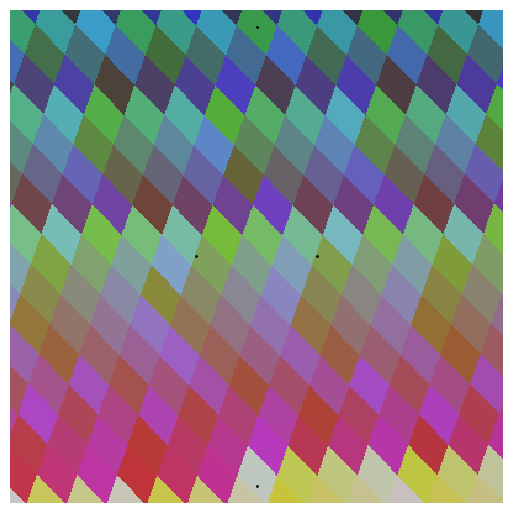

In [20]:
# Rot is closest point on detector
hp.gnomview(np.arange(hmap), rot=transform[1:], xsize=400, reso=0.25, notext=True, cmap=Healpy_cmap, cbar=False, title='')
# hp.graticule(zorder=0)
plt.savefig('Plots/test_no_point.png', bbox_inches='tight')
for x in np.linspace(-1, 1, 2):
    for y in np.linspace(-1, 1, 2): 
        hp.projscatter(cart2sph(shift+np.array([x,y,0]))[1:], lonlat=True, color='black', s=1)
plt.savefig('Plots/test_with_point.png', bbox_inches='tight')

# temp = np.asarray(Image.open('Plots/test_with_point.png'))[:,:,:-1]
# res = np.argwhere(temp == np.array([0,0,0]))[0::3, :-1].T
# order = np.argsort(np.arctan2(res[1] - res[1].mean(), res[0] - res[0].mean()))
# plt.fill(res[1][order], res[0][order], "black")
# plt.savefig('Plots/test_with_box.png', bbox_inches='tight')

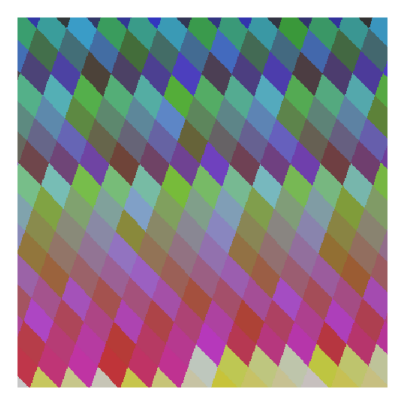

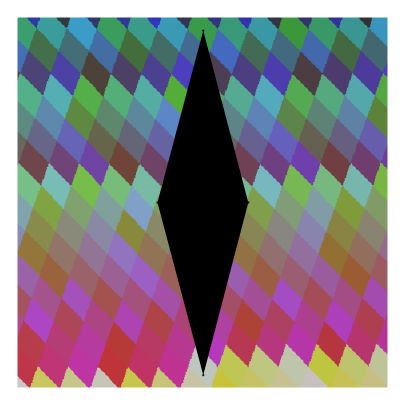

In [24]:
image = np.asarray(Image.open('Plots/test_no_point.png'))[:,:,:-1]
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.gca().axis('off')
plt.savefig('Plots/test_no_point_new.png', dpi=100, facecolor='None', bbox_inches='tight')
plt.show()

temp = np.asarray(Image.open('Plots/test_with_point.png'))[:,:,:-1]
res = np.argwhere(temp == np.array([0,0,0]))[0::3, :-1].T
order = np.argsort(np.arctan2(res[1] - res[1].mean(), res[0] - res[0].mean()))

plt.figure(figsize=(5,5))
plt.imshow(temp)
plt.fill(res[1][order], res[0][order], "black")
plt.gca().axis('off')
plt.savefig('Plots/test_with_box.png', dpi=100, facecolor='None', bbox_inches='tight')
plt.show()

In [26]:
before = np.asarray(Image.open('Plots/test_no_point_new.png'))[:,:,:-1]
after = np.asarray(Image.open('Plots/test_with_box.png'))[:,:,:-1]

In [32]:
colorb = {}

for i in before.reshape(before.shape[0]*before.shape[1],3):
    if str(i) not in colorb:
        colorb[str(i)] = 0
    colorb[str(i)] += 1

In [36]:
colorb["[ 58 150 146]"]

513

In [40]:
colora = {i: 0 for i in colorb}

for i in after.reshape(after.shape[0]*after.shape[1],3):
    if str(i) not in colora:
        colora[str(i)] = 0
    colora[str(i)] += 1

In [35]:
colora

{'[255 255 255]': 25979,
 '[205 230 219]': 1,
 '[156 206 183]': 29,
 '[154 181 196]': 1,
 '[152 156 210]': 12,
 '[152 157 209]': 1,
 '[156 204 205]': 1,
 '[156 206 205]': 15,
 '[154 182 182]': 1,
 '[152 156 157]': 12,
 '[152 156 158]': 1,
 '[156 203 223]': 1,
 '[156 205 227]': 15,
 '[154 182 205]': 1,
 '[152 155 179]': 13,
 '[153 164 178]': 1,
 '[156 205 174]': 15,
 '[154 183 185]': 1,
 '[152 155 201]': 14,
 '[154 176 198]': 1,
 '[156 205 196]': 15,
 '[153 170 214]': 1,
 '[152 154 223]': 12,
 '[153 161 222]': 1,
 '[156 204 218]': 15,
 '[154 184 199]': 1,
 '[152 154 170]': 14,
 '[154 173 168]': 1,
 '[156 204 165]': 15,
 '[153 172 182]': 1,
 '[152 154 192]': 13,
 '[153 172 190]': 1,
 '[156 204 187]': 15,
 '[154 172 203]': 1,
 '[152 153 214]': 13,
 '[153 170 212]': 1,
 '[156 203 209]': 15,
 '[154 173 180]': 1,
 '[152 153 161]': 13,
 '[153 169 159]': 1,
 '[156 203 156]': 15,
 '[154 174 171]': 1,
 '[152 153 183]': 14,
 '[154 181 180]': 1,
 '[156 203 178]': 15,
 '[153 161 200]': 1,
 '[152 15

In [38]:
len(colorb.keys())

8386

In [75]:
fracs = 1 - np.array([colora[i]/colorb[i] for i in colorb if colorb[i] > 100])

In [78]:
fracs[fracs != 0] # not covered fraction

array([0.14150943, 0.40683761, 0.32423208, 0.39232053, 0.98641766,
       0.24914676, 0.17428088, 1.        , 0.26395939, 1.        ,
       0.95918367, 0.09899329, 1.        , 1.        , 0.16282895,
       0.02538071, 1.        , 1.        , 0.89428076, 0.95945946,
       1.        , 1.        , 0.03395586, 0.25888325, 1.        ,
       1.        , 0.12585034, 0.99313894, 1.        , 0.20272572,
       0.28209459, 1.        , 0.38435374, 0.99833611, 0.36531987,
       0.5177665 , 0.44630872, 0.53145695, 0.29610829])

In [81]:
(sum(fracs[fracs != 0])/hmap)*100 # percentage covered

0.0007825043355392379